# Temperature prediction with XGBoost

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pathlib import Path
plt.style.use('seaborn-v0_8-whitegrid')

DATA_DIR = Path('data')

df = pd.read_csv(DATA_DIR / 'combined.csv', parse_dates=['time'], index_col='time')
targets = pd.read_csv(DATA_DIR / 'targets_day_night_temp.csv', parse_dates=['time'], index_col='time')


In [2]:
def train_and_eval(data, target_col, model_name, test_days=365):
    train = data.iloc[:-test_days]
    test = data.iloc[-test_days:]

    X_train = train.drop(columns=[target_col])
    y_train = train[target_col]
    X_test = test.drop(columns=[target_col])
    y_test = test[target_col]

    model = xgb.XGBRegressor(
        n_estimators=1500,
        learning_rate=0.02,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8, # Tutaj bierzemy więcej cech (0.8) niż w multi, bo mamy ich mało
        random_state=42,
        n_jobs=-1,
        early_stopping_rounds=50
    )

    # Walidacja
    split = int(len(X_train) * 0.9)
    model.fit(
        X_train.iloc[:split], y_train.iloc[:split],
        eval_set=[(X_train.iloc[split:], y_train.iloc[split:])],
        verbose=0
    )

    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    print(f"[{model_name}] RMSE: {rmse:.2f}°C | MAE: {mae:.2f}°C | R2: {r2:.4f}")

    return y_test, preds, model

In [3]:
def show_results(day_result, night_result):
    y_day, p_day, m_day = day_result
    y_night, p_night, m_night = night_result
    fig, ax = plt.subplots(2, 1, figsize=(12, 10))

    # Wykres Dnia
    subset = 60
    ax[0].plot(
        y_day.index[-subset:],
        y_day.values[-subset:],
        "o-",
        color="orange",
        label="Rzeczywista (Dzień)",
        alpha=0.6,
    )
    ax[0].plot(
        y_day.index[-subset:],
        p_day[-subset:],
        "x--",
        color="black",
        label="Prognoza Single",
    )
    ax[0].set_title("Prognoza Dnia (Dane tylko Wrocław 06:00)")
    ax[0].legend()

    # Wykres Nocy
    ax[1].plot(
        y_night.index[-subset:],
        y_night.values[-subset:],
        "o-",
        color="navy",
        label="Rzeczywista (Noc)",
        alpha=0.6,
    )
    ax[1].plot(
        y_night.index[-subset:],
        p_night[-subset:],
        "x--",
        color="red",
        label="Prognoza Single",
    )
    ax[1].set_title("Prognoza Nocy (Dane tylko Wrocław 18:00)")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

    # Importancja cech
    plt.figure(figsize=(10, 5))
    xgb.plot_importance(
        m_night,
        max_num_features=12,
        importance_type="gain",
        title="Co decyduje o nocy (Single Station)?",
    )
    plt.show()

In [4]:

def create_single_station_dataset(df_raw, snapshot_hour, target_series):
    print(f"Budowanie datasetu dla Snapshota: {snapshot_hour}:00 ---")

    # 1. Główny Snapshot (Moment startu prognozy)
    df_snap = df_raw[df_raw.index.hour == snapshot_hour].copy()
    df_snap.index = df_snap.index.normalize() # Data bez godziny

    # 2. Dane "Historyczne" (dla obliczenia trendów)
    # Pobieramy dane sprzed 3 godzin i sprzed 1 godziny
    # Uwaga: Musimy obsłużyć przejście przez północ (dla godziny 0-2),
    # ale zakładając snapshoty 15 i 3 wystarczy proste odcięcie

    lag_1h_idx = (snapshot_hour - 1)
    lag_3h_idx = (snapshot_hour - 3)

    df_lag1 = df_raw[df_raw.index.hour == lag_1h_idx].copy()
    df_lag3 = df_raw[df_raw.index.hour == lag_3h_idx].copy()

    # Normalizacja indeksów, żeby pasowały do df_snap
    df_lag1.index = df_lag1.index.normalize()
    df_lag3.index = df_lag3.index.normalize()

    # 3. Budowa Cech (X)
    X = pd.DataFrame(index=df_snap.index)

    # Stan Aktualny
    cols_current = ['temp', 'pres', 'rhum', 'wspd', 'cldc', 'prcp']
    for col in cols_current:
        if col in df_snap.columns:
            X[f'{col}_now'] = df_snap[col]

    # Fizyka: Trendy
    # Jak szybko zmienia się ciśnienie? (Ważne dla frontów)
    X['pres_trend_3h'] = df_snap['pres'] - df_lag3['pres']

    # Jak szybko zmienia się temperatura? (Dynamika nagrzewania/chłodzenia)
    X['temp_trend_1h'] = df_snap['temp'] - df_lag1['temp']
    X['temp_trend_3h'] = df_snap['temp'] - df_lag3['temp']

    # Punkt rosy (Dew Point)
    # Uproszczone przybliżenie: T - ((100 - RH)/5)
    X['dew_point_approx'] = X['temp_now'] - ((100 - X['rhum_now']) / 5)

    # 4. Łączenie z Celem
    data = X.join(target_series, how='inner')
    return data

Budowanie datasetu dla Snapshota: 18:00 ---
Budowanie datasetu dla Snapshota: 22:00 ---
[MODEL DNIA] RMSE: 2.52°C | MAE: 1.89°C | R2: 0.9063
[MODEL NOCY] RMSE: 2.76°C | MAE: 2.17°C | R2: 0.8415


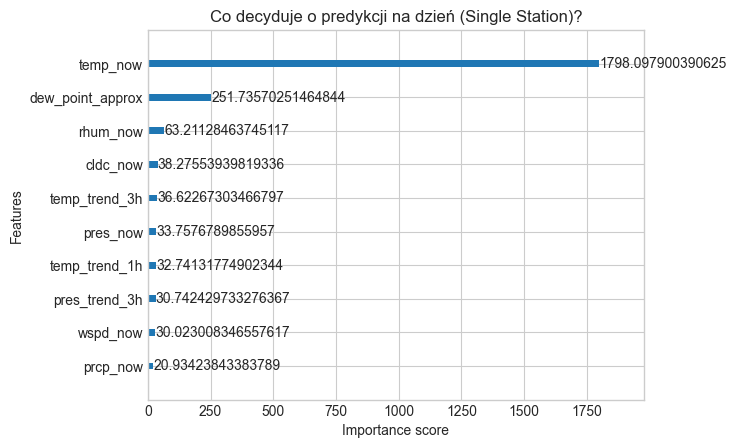

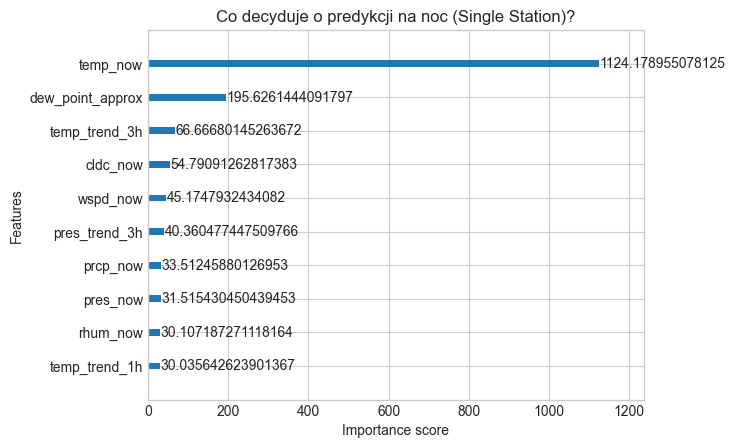

In [5]:
data_day = create_single_station_dataset(df, snapshot_hour=18, target_series=targets['target_temp_day'])
data_night = create_single_station_dataset(df, snapshot_hour=22, target_series=targets['target_temp_night'])

day_results = train_and_eval(data_day, 'target_temp_day', 'MODEL DNIA')
night_results = train_and_eval(data_night, 'target_temp_night', 'MODEL NOCY')

modal_day = day_results[2]
xgb.plot_importance(modal_day, max_num_features=12, importance_type='gain', title='Co decyduje o predykcji na dzień (Single Station)?')

model_night = night_results[2]
xgb.plot_importance(model_night, max_num_features=12, importance_type='gain', title='Co decyduje o predykcji na noc (Single Station)?')
plt.show()

In [6]:
data_day.head()

,temp_now,pres_now,rhum_now,wspd_now,cldc_now,prcp_now,pres_trend_3h,temp_trend_1h,temp_trend_3h,dew_point_approx,target_temp_day
time,,,,,,,,,,,
2018-01-01,6.2,1006.2,72.0,14.4,5.0,0.0,0.2,-0.3,-1.2,0.6,4.508333
2018-01-02,4.8,1011.1,88.0,14.4,8.0,0.0,1.5,0.1,0.7,2.4,4.258333
2018-01-03,6.1,993.5,70.0,28.8,7.0,0.0,2.7,0.3,-0.3,0.1,6.941667
2018-01-04,4.7,998.6,78.0,10.8,2.0,0.0,-0.7,-2.0,-2.2,0.3,8.358333
2018-01-05,9.2,1002.0,74.0,18.0,8.0,0.0,1.1,-0.3,0.6,4.0,8.483333


In [7]:
def create_single_station_dataset_2(df, snapshot_hour, target_series):

    df = df.copy()
    df = df[df.index.hour <= snapshot_hour]

    base_cols = ["temp", "pres", "rhum", "wspd", "prcp"]
    df_base = df[base_cols]

    X = pd.DataFrame(index=df.index)

    # 1. LAG FEATURES
    lags = [1, 3, 6, 12, 24]

    for col in ["temp", "pres", "rhum", "wspd"]:
        for lag in lags:
            X[f"{col}_lag_{lag}h"] = df_base[col].shift(lag)

    # 2. TRENDS (DIFFERENCES)
    X["temp_trend_3h"] = df_base["temp"] - df_base["temp"].shift(3)
    X["temp_trend_12h"] = df_base["temp"] - df_base["temp"].shift(12)

    X["pres_trend_6h"] = df_base["pres"] - df_base["pres"].shift(6)
    X["pres_trend_24h"] = df_base["pres"] - df_base["pres"].shift(24)

    # 3. ROLLING STATS
    for win in [6, 24]:
        X[f"temp_mean_{win}h"] = df_base["temp"].shift(1).rolling(win).mean()
        X[f"temp_std_{win}h"] = df_base["temp"].shift(1).rolling(win).std()

        X[f"pres_mean_{win}h"] = df_base["pres"].shift(1).rolling(win).mean()
        X[f"pres_std_{win}h"] = df_base["pres"].shift(1).rolling(win).std()

    # 4. WILGOTNOŚĆ / PUNKT ROSY
    X["dew_point_approx"] = df_base["temp"] - ((100 - df_base["rhum"]) / 5)

    # 5. CZAS (CYKLICZNY)
    idx = df.index
    X["day_year_sin"] = df["day_year_sin"]
    X["day_year_cos"] = df["day_year_cos"]
    X["month"] = df["month"]
    wdir = df['wdir']
    df['wdir_sin'] = np.sin(np.deg2rad(wdir))
    df['wdir_cos'] = np.cos(np.deg2rad(wdir))

    X = X[X.index.hour == snapshot_hour]
    X.index = X.index.normalize()
    data = X.join(target_series, how="inner")
    return data

[MODEL DNIA] RMSE: 2.46°C | MAE: 1.91°C | R2: 0.9109
[MODEL NOCY] RMSE: 2.57°C | MAE: 2.07°C | R2: 0.8624


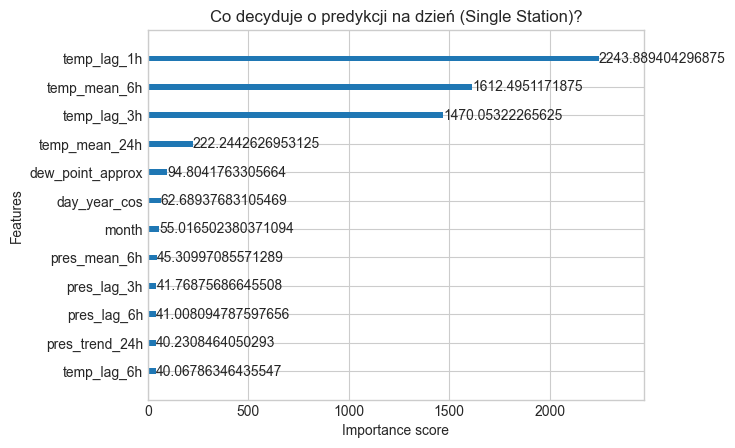

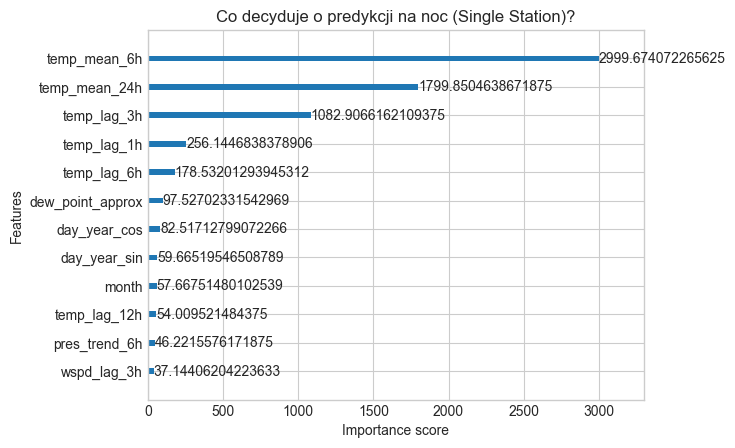

In [8]:
data_day = create_single_station_dataset_2(df, snapshot_hour=17, target_series=targets['target_temp_day'])
data_night = create_single_station_dataset_2(df, snapshot_hour=22, target_series=targets['target_temp_night'])

day_results = train_and_eval(data_day, 'target_temp_day', 'MODEL DNIA')
night_results = train_and_eval(data_night, 'target_temp_night', 'MODEL NOCY')

modal_day = day_results[2]
xgb.plot_importance(modal_day, max_num_features=12, importance_type='gain', title='Co decyduje o predykcji na dzień (Single Station)?')

model_night = night_results[2]
xgb.plot_importance(model_night, max_num_features=12, importance_type='gain', title='Co decyduje o predykcji na noc (Single Station)?')
plt.show()